In [1]:
import sys

from paths import DATA_DIR, FIG_DIR

import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

from graphvelo.graph_velocity import GraphVelo
from graphvelo.utils import adj_to_knn, mack_score
import project
from graphvelo.plot import gene_score_histogram

In [2]:
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params(
    "scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis"
)
scv.settings.plot_prefix = ""

In [3]:
save_figure = True

In [4]:
import cellrank as cr
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Velocity estimation using scvelo

In [6]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata)

recovering dynamics (using 16/16 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

    finished (0:03:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


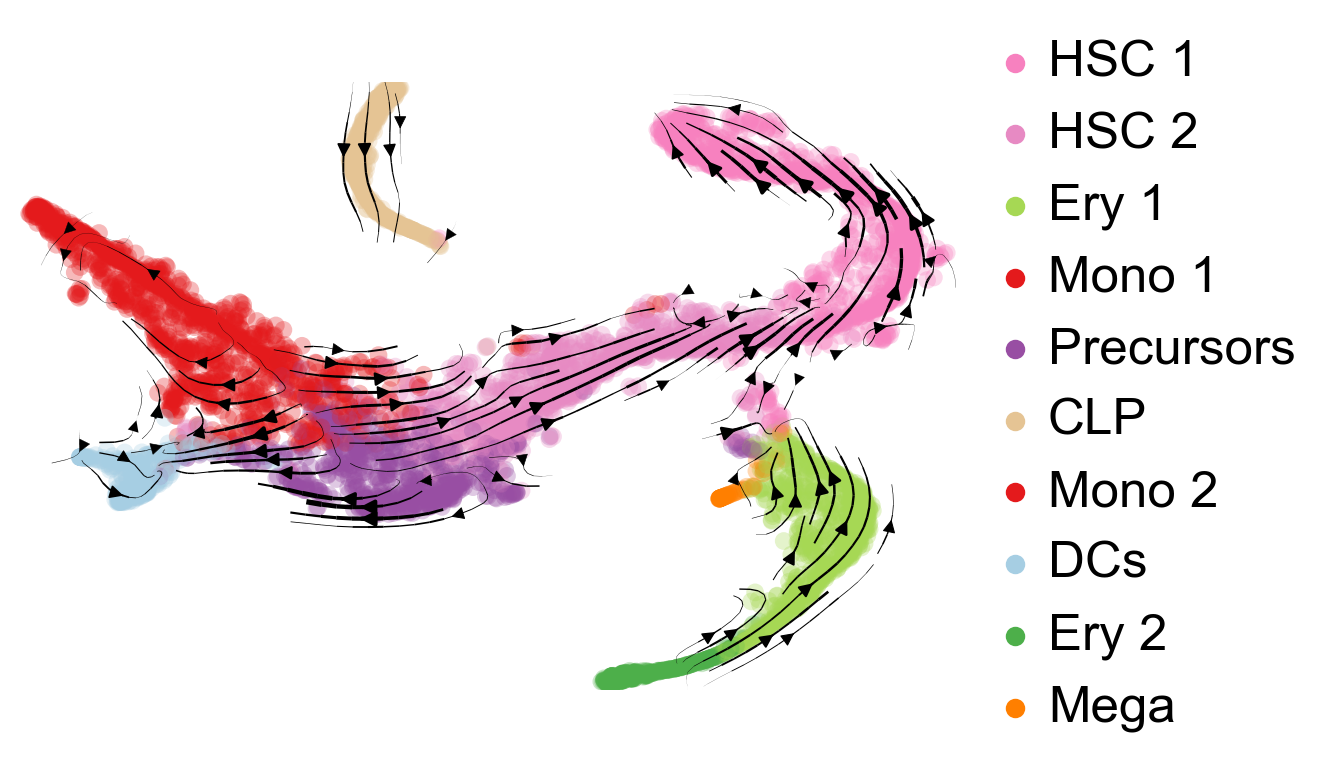

In [8]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [10]:
genes = ["ANGPT1", "RBPMS"]

C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


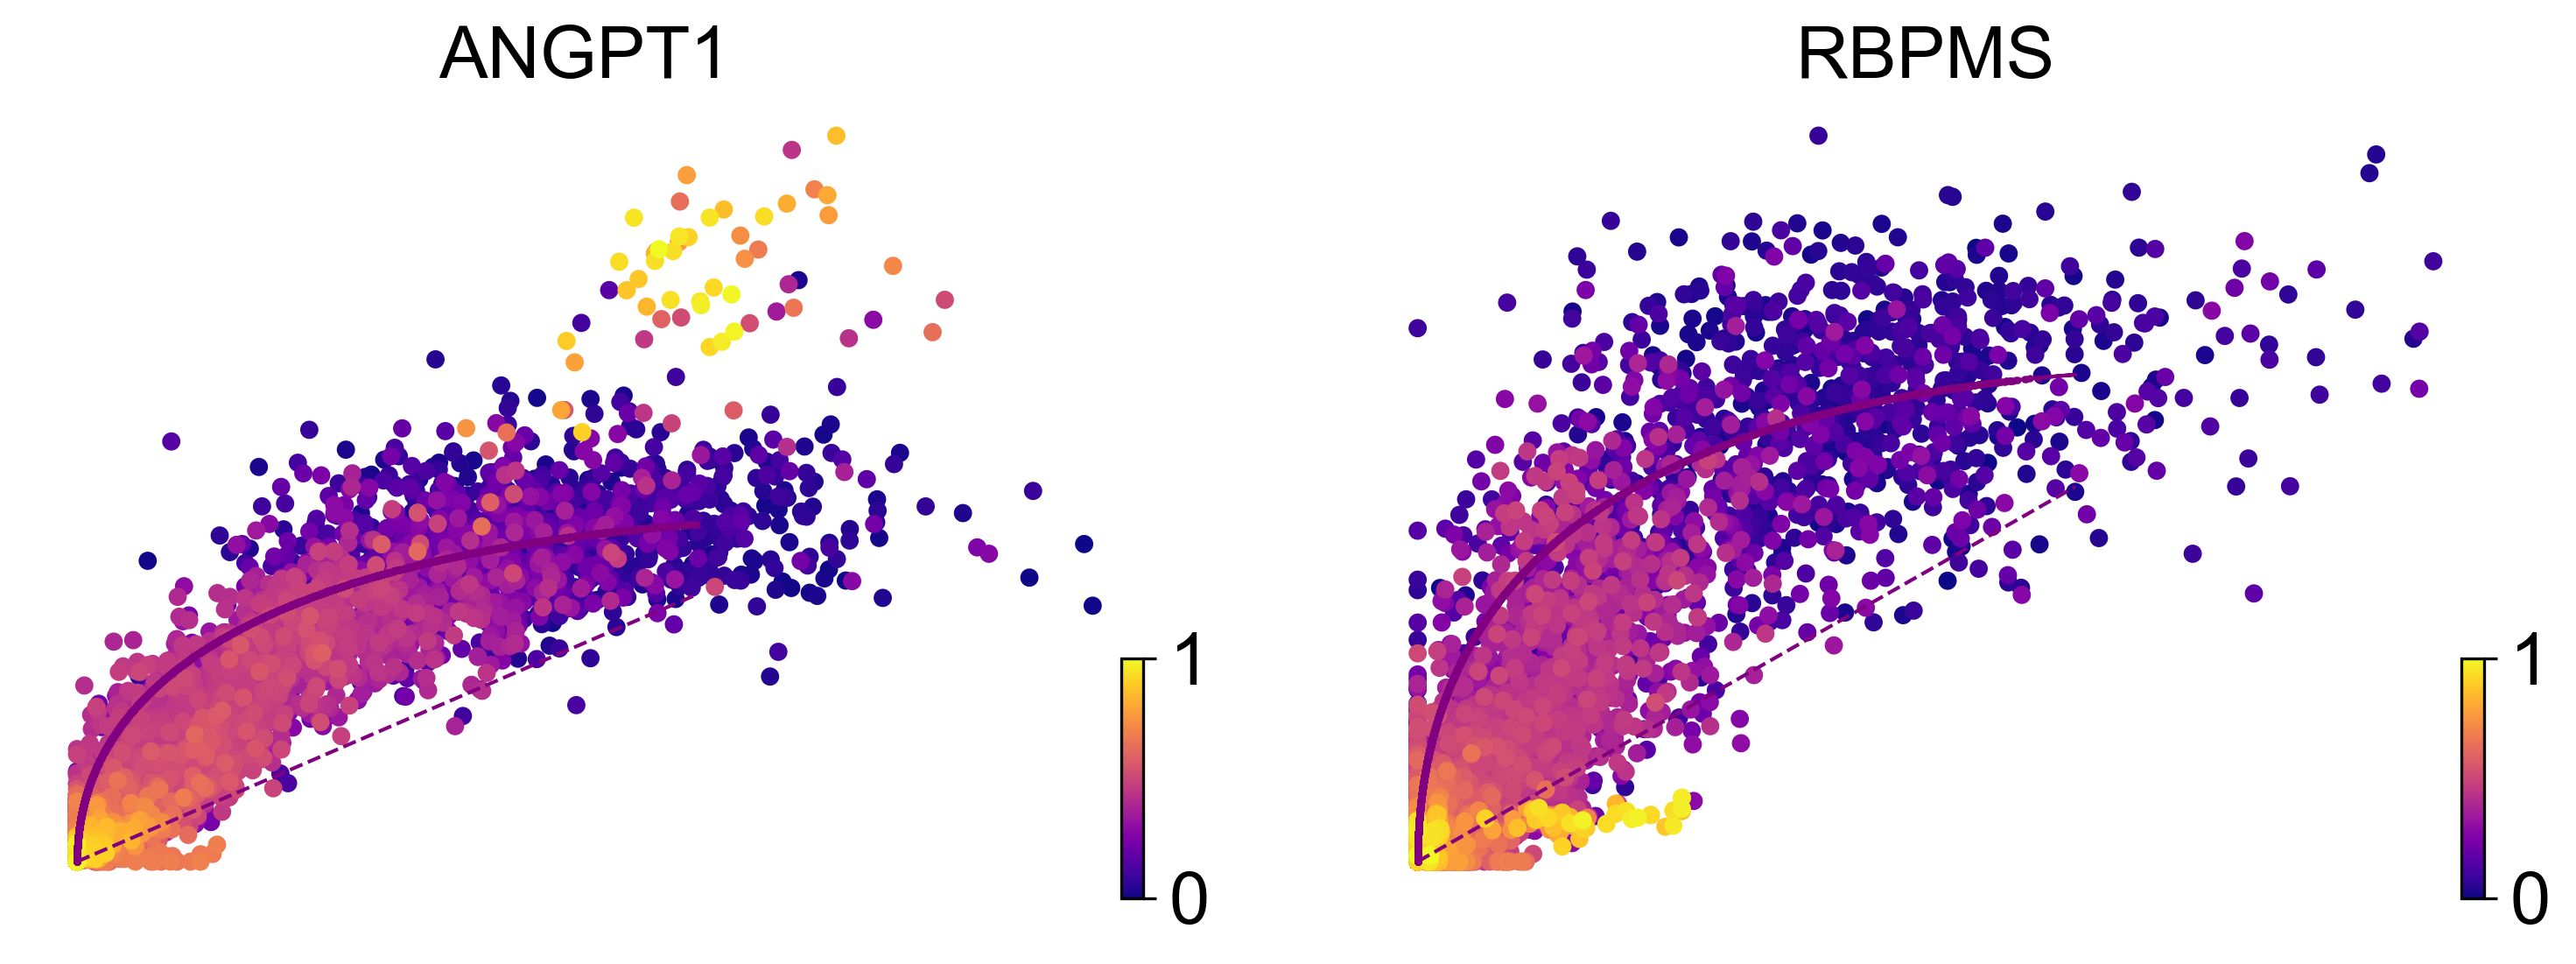

In [11]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
scv.pl.scatter(adata, **fig_kwargs)

In [12]:
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis="pca")


computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [15]:
indices, _ = adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [18]:
mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

calculating manifold-consistent scores in 16 cpu(s): 100%|███████████████████████████████| 588/588 [00:43<00:00, 13.38it/s]


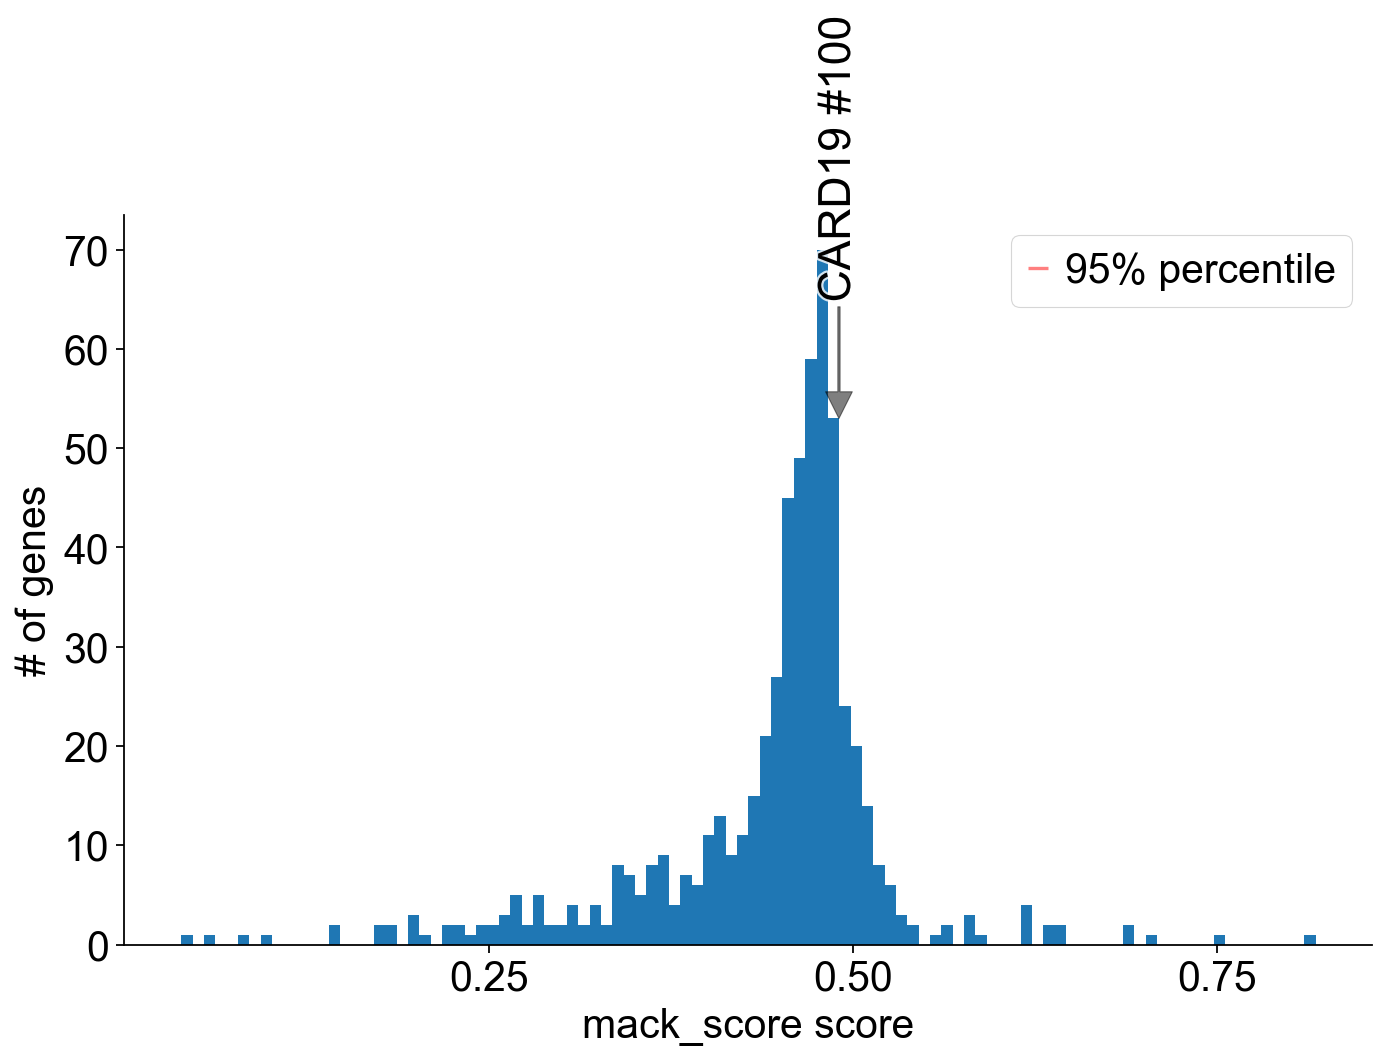

In [19]:
nbrs_idx = adata.uns['neighbors']['indices']
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

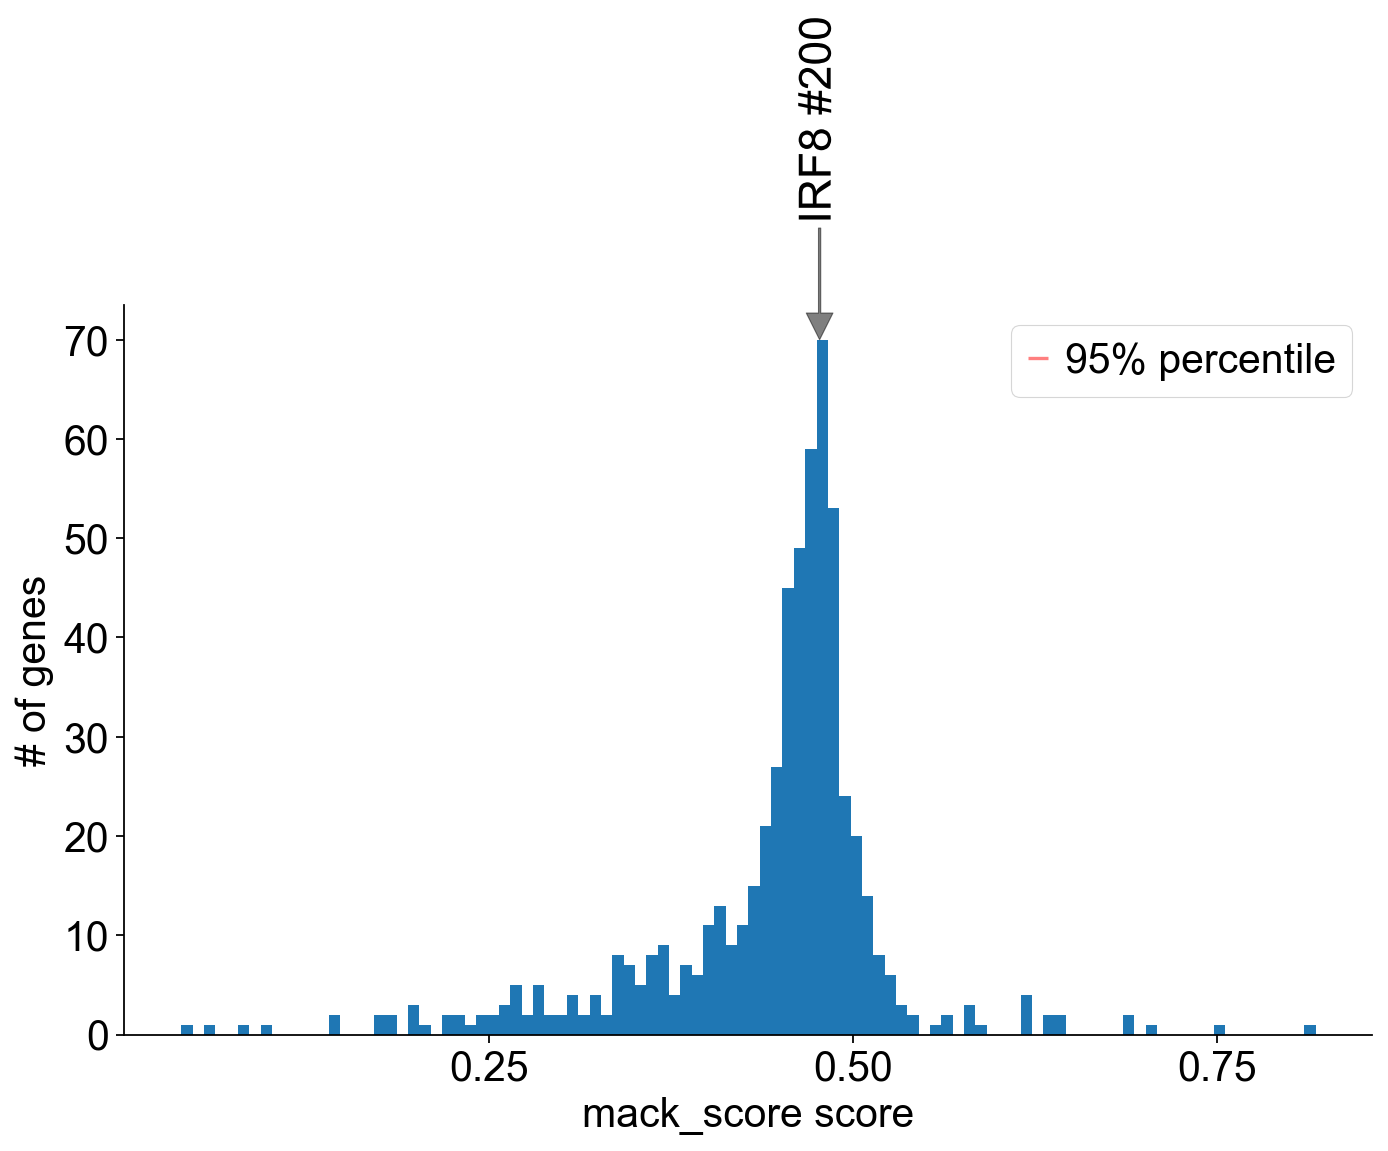

In [21]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|██████████████████████████████████████| 5780/5780 [00:28<00:00, 202.77it/s]
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


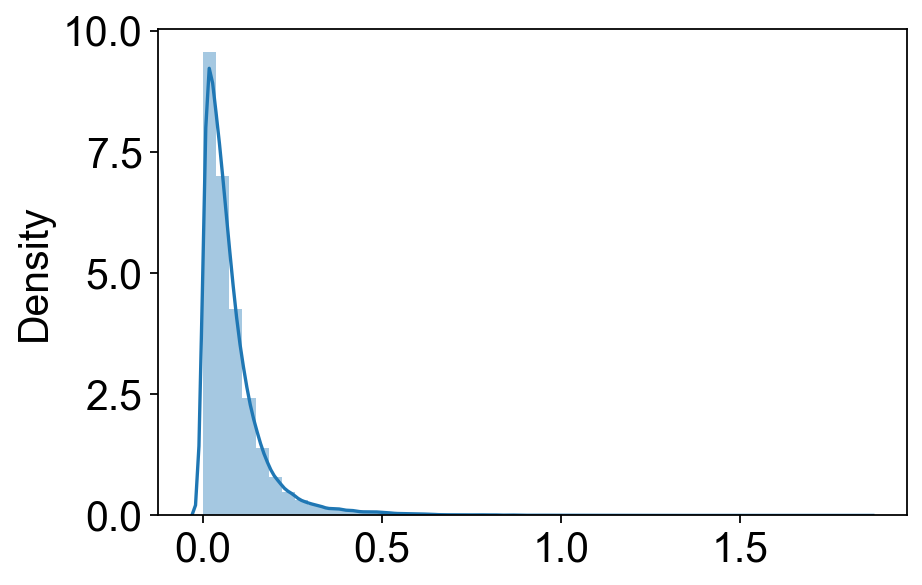

In [22]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [24]:
project.gv.mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

340it [01:32,  4.02it/s]Executing <Handle IOLoop._run_callback(functools.par...01B2A8E25760>)) created at C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\tornado\platform\asyncio.py:241> took 0.156 seconds
519it [02:24,  3.85it/s]Executing <Handle IOLoop._run_callback(functools.par...01B2A8E25F80>)) created at C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\tornado\platform\asyncio.py:241> took 0.125 seconds
588it [02:43,  3.59it/s]


In [25]:
nbrs_idx = adata.uns['neighbors']['indices']

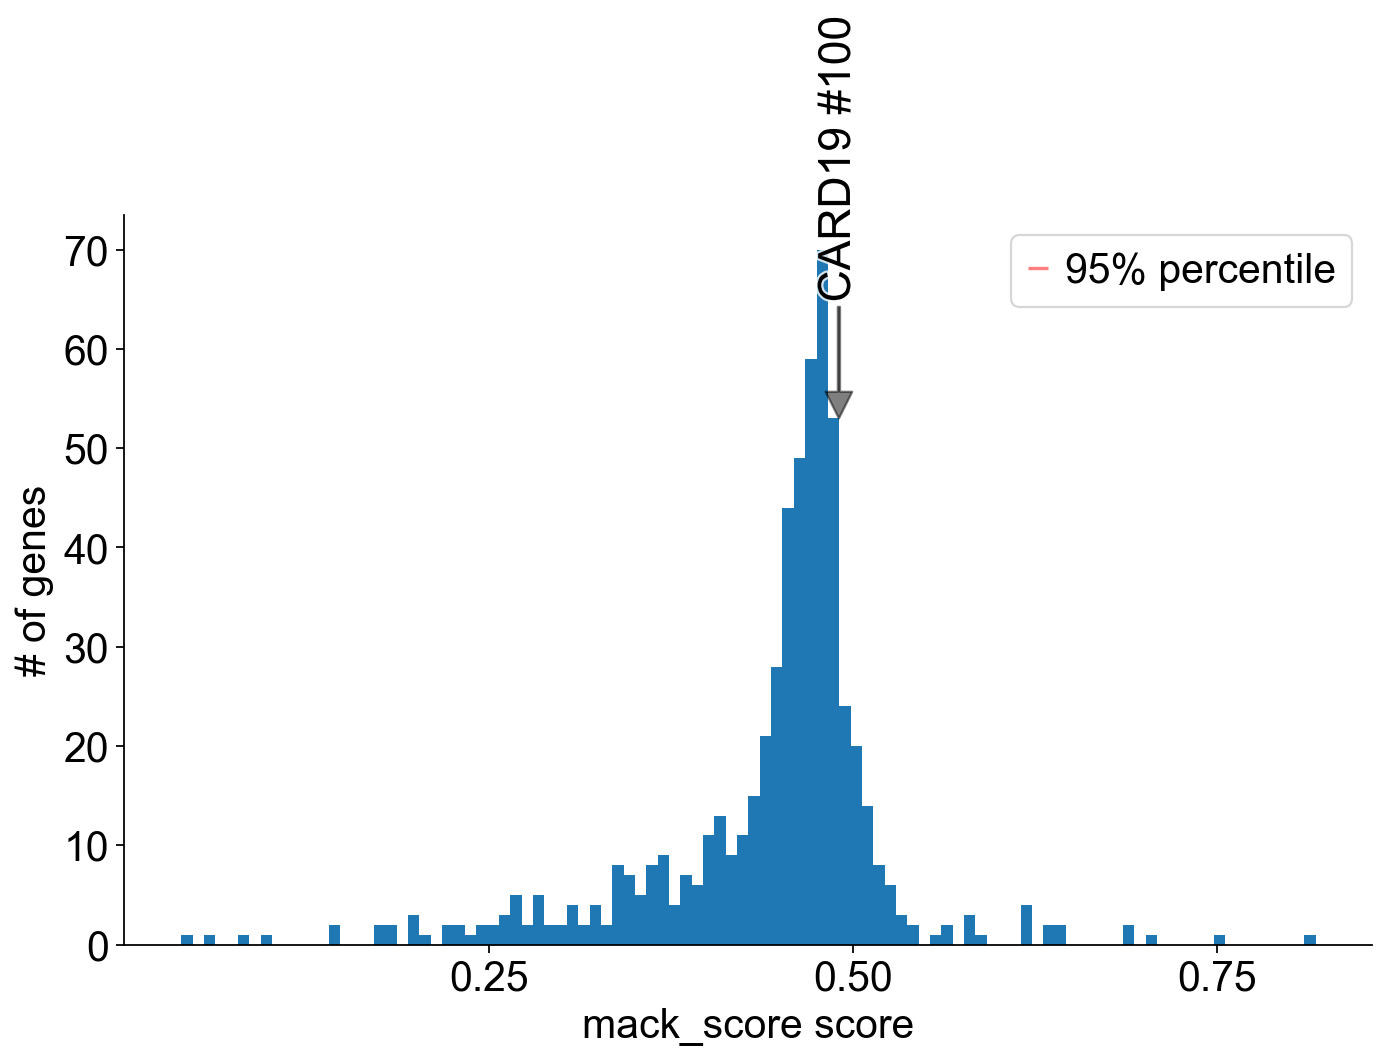

In [26]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

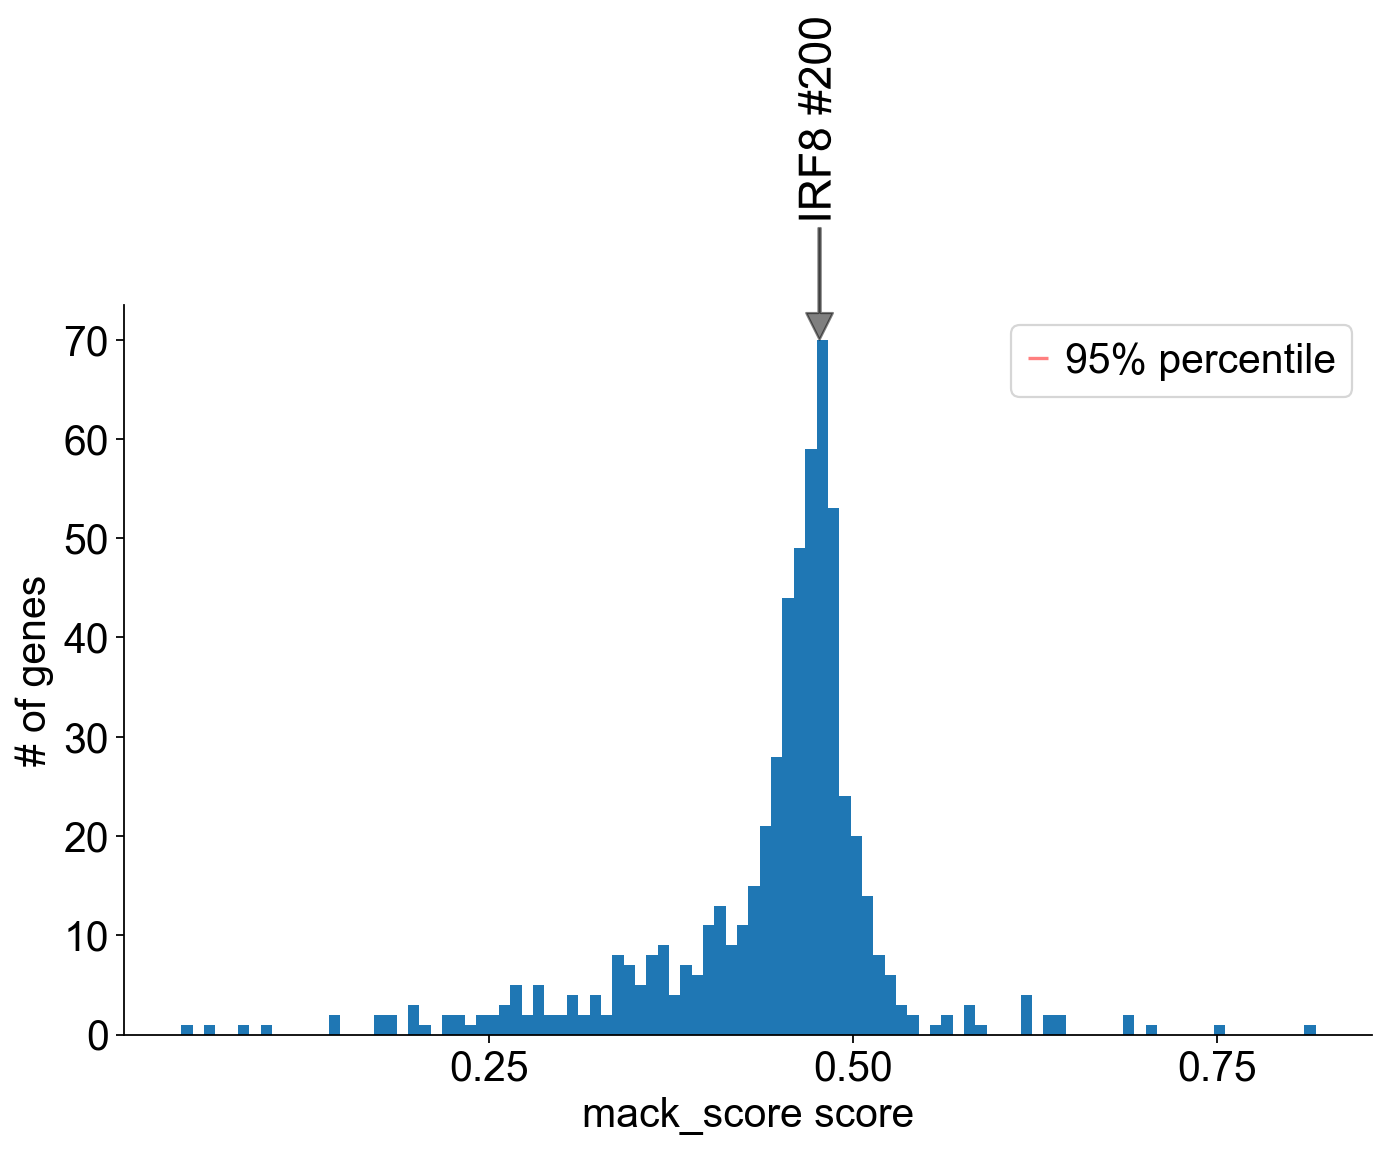

In [27]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|██████████████████████████████████████| 5780/5780 [00:49<00:00, 117.33it/s]
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


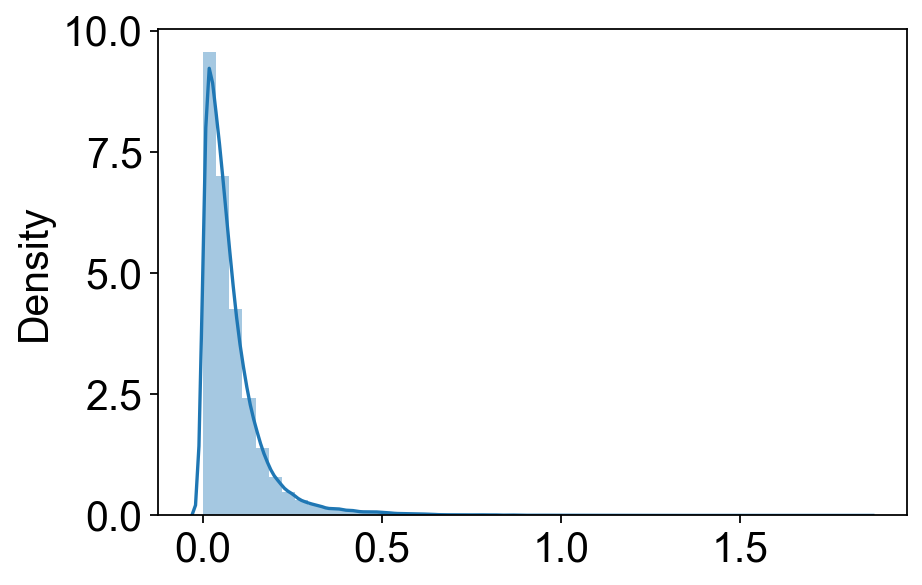

In [28]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [57]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


In [36]:

scvelo_gamma = adata.var['fit_gamma']  # shape: (n_genes,)
print(scvelo_gamma.head())


index
CCNL2          NaN
CDK11A         NaN
NADK      0.213168
CEP104         NaN
RERE           NaN
Name: fit_gamma, dtype: float64


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


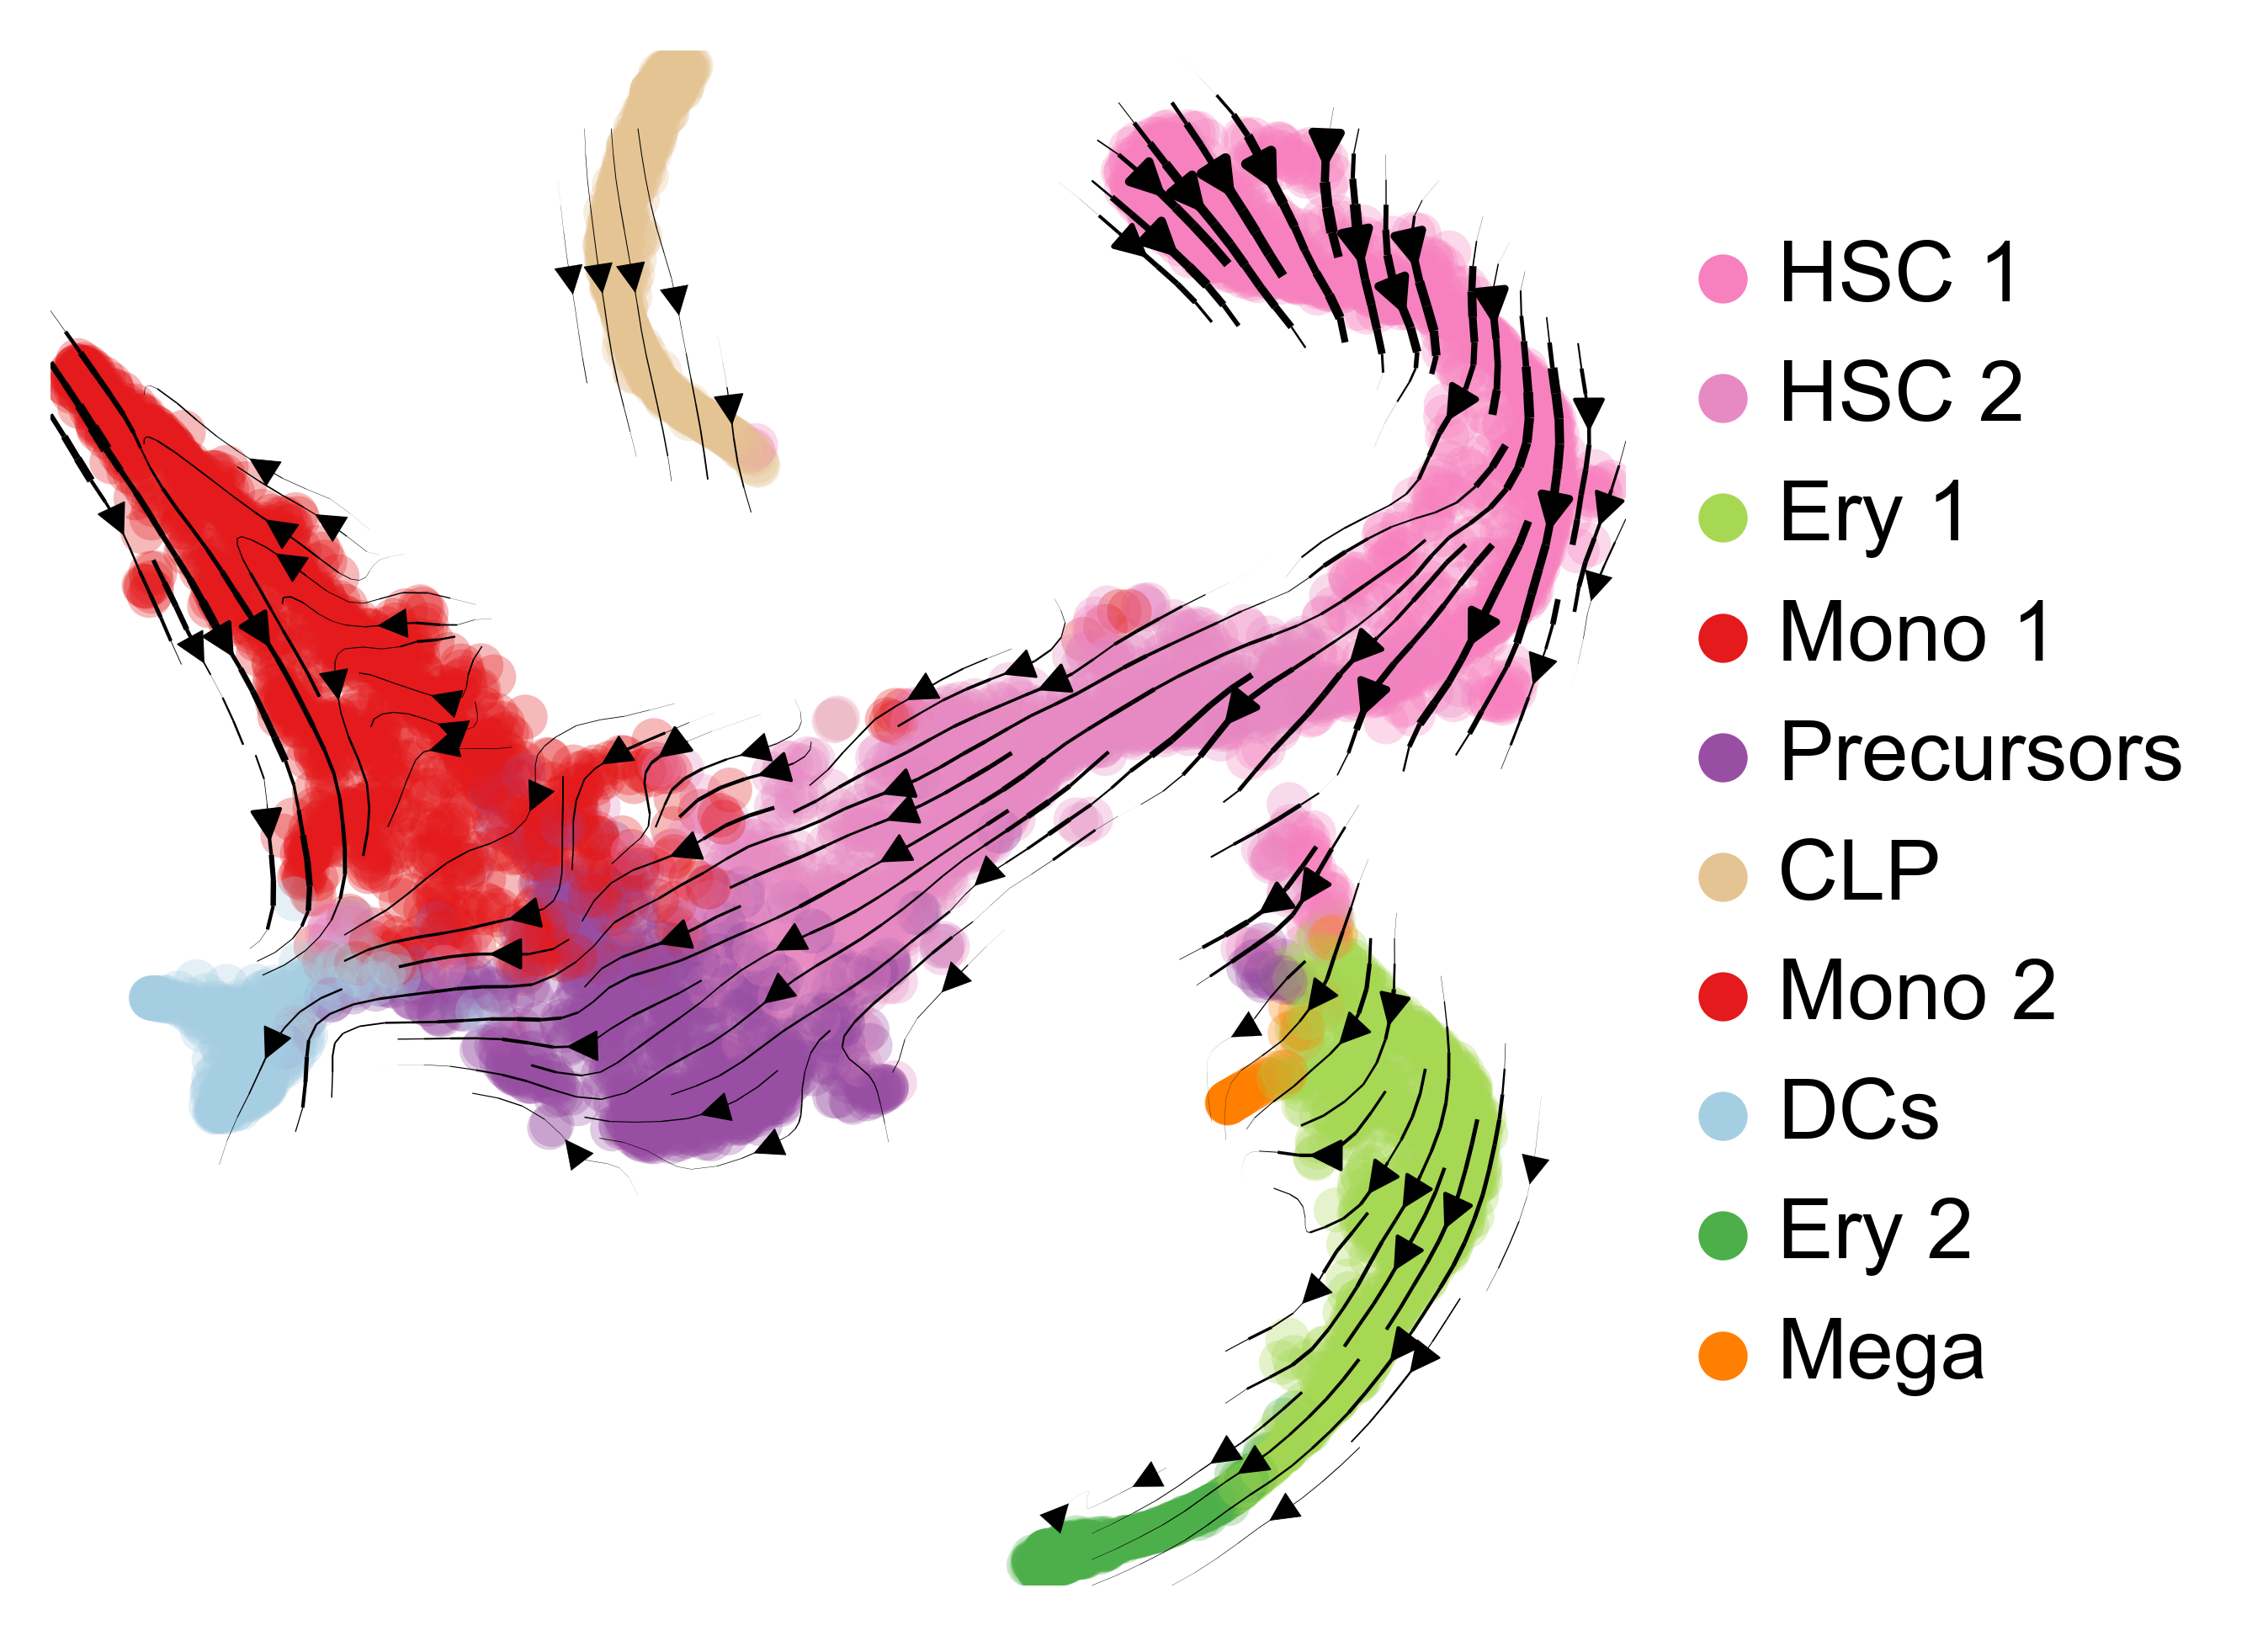

In [38]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\project\plotting\impl.py:116: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  and is_categorical_dtype(adata.obs[color])
Plotting velocity in phase diagram: 100%|████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


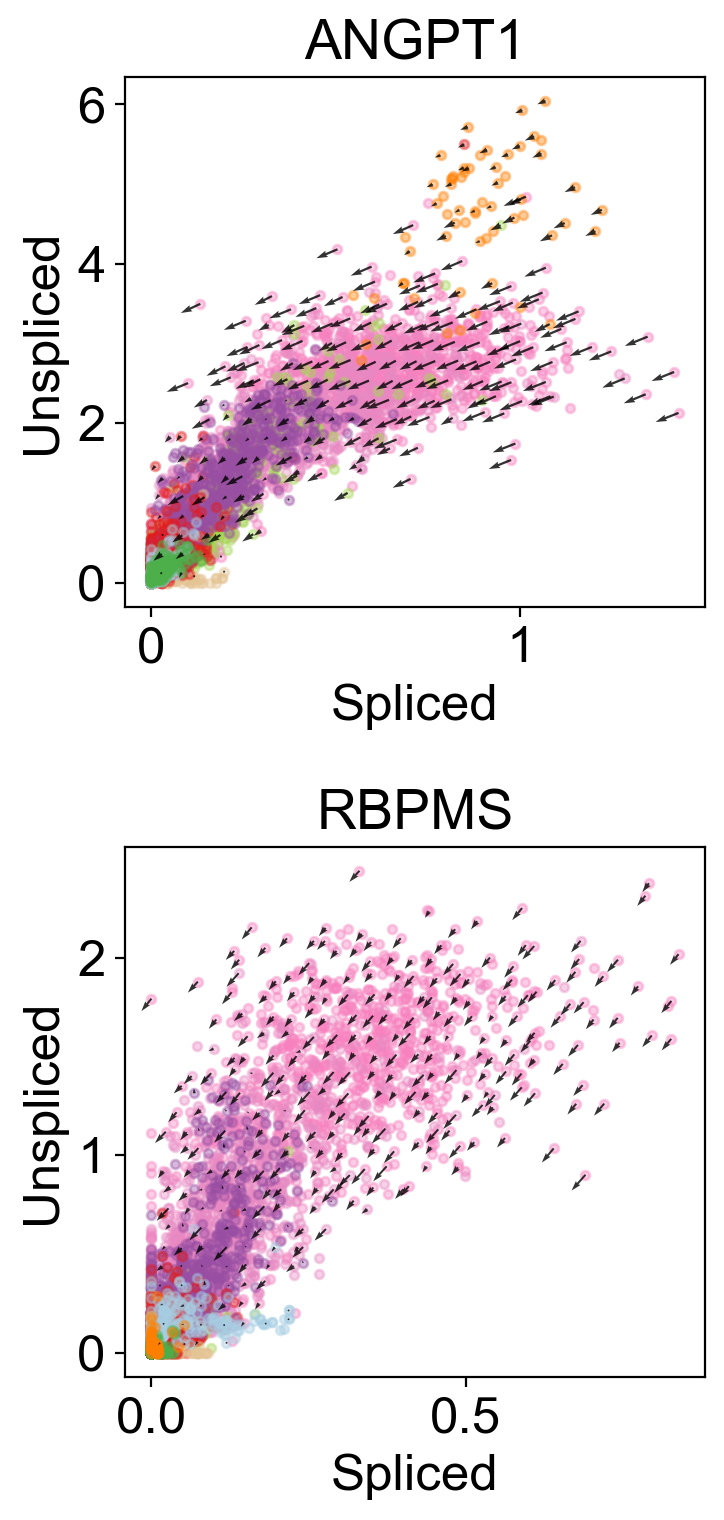

In [39]:
from project.plotting.impl import plot_velocity_phase
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

Plotting velocity in phase diagram: 100%|████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


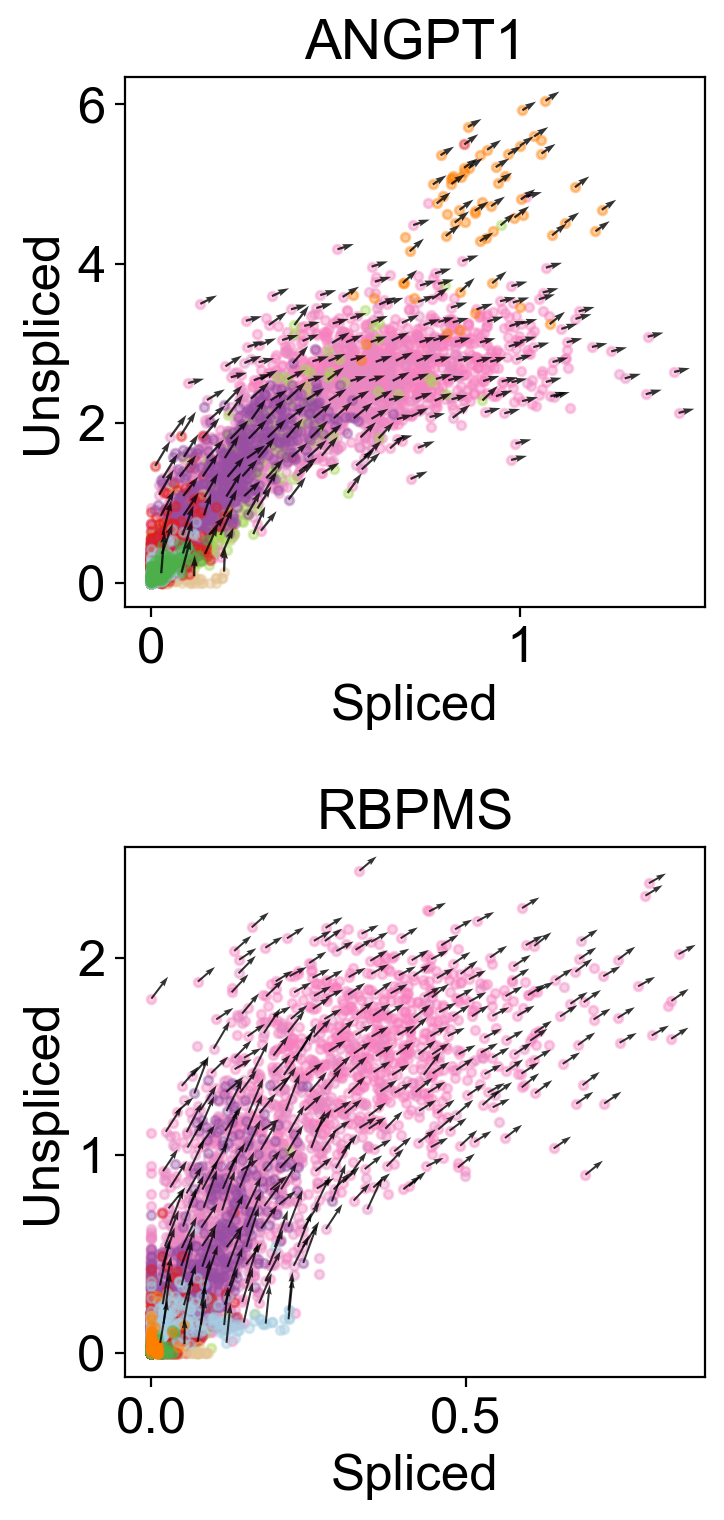

In [40]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()

In [41]:
adata.write("hspc_gv.h5ad")

In [44]:
# calculate CBC score for both scVelo and GraphVelo with the same transition of HSC -> Ery
from project.graphvelo.metric import cross_boundary_correctness_one_transition
transition = ("HSC_1", "Ery_1")
V_data_scvelo = adata.obsm["velocity_pca"]

cbc_score_sc = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data_scvelo,
    annotation_key="clusters",
    reduce_space_key="X_pca",   # <-- FIXED
    neighbor_key="neighbors"
)

cbc_score_gv = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data = adata.obsm["gv_pca"],
    annotation_key="clusters",
    reduce_space_key="X_pca",
    neighbor_key="neighbors"
)

print("CBC score scVelo:", cbc_score_sc)
print("CBC score GraphVelo:", cbc_score_gv)


CBC score scVelo: -0.02072542615503713
CBC score GraphVelo: 0.016594317288943623


In [48]:
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'palantir', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'gv_params'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'X_pca', 'velocity_tsne', 'velocity_pca', 'gv_pca', 'gv_tsne'
    varm: 'PCs', 'loss'
    layer

In [52]:
adata.obs['clusters'].value_counts()

clusters
HSC_1         1118
HSC_2          984
Ery_1          742
Mono_1         724
Precursors     666
CLP            488
Mono_2         429
DCs            303
Ery_2          265
Mega            61
Name: count, dtype: int64

In [54]:

transitions = [
    ("HSC_1", "HSC_2"),          # stem cell subtypes
    ("HSC_2", "Precursors"),     # multipotent progenitors
    ("Precursors", "Ery_1"),     # erythroid lineage start
    ("Ery_1", "Ery_2"),          # erythroid maturation
    ("Precursors", "Mono_1"),    # monocyte lineage start
    ("Mono_1", "Mono_2"),        # monocyte maturation
    ("Mono_2", "DCs"),           # dendritic cell differentiation
    ("Precursors", "CLP"),       # lymphoid progenitor branch
    ("Precursors", "Mega") ]      # megakaryocyte branch
V_data_scvelo = adata.obsm["velocity_pca"]
cbc_sc_all = []
cbc_gv_all = []
for transition in transitions:
    cbc_score_sc = cross_boundary_correctness_one_transition(
        adata,
        transition,
        V_data_scvelo,
        annotation_key="clusters",
        reduce_space_key="X_pca",   # <-- FIXED
        neighbor_key="neighbors"
     )

    cbc_score_gv = cross_boundary_correctness_one_transition(
        adata,
        transition,
        V_data = adata.obsm["gv_pca"],
        annotation_key="clusters",
        reduce_space_key="X_pca",
        neighbor_key="neighbors"
     )    
    cbc_sc_all.append(cbc_score_sc)
    cbc_gv_all.append(cbc_score_gv)




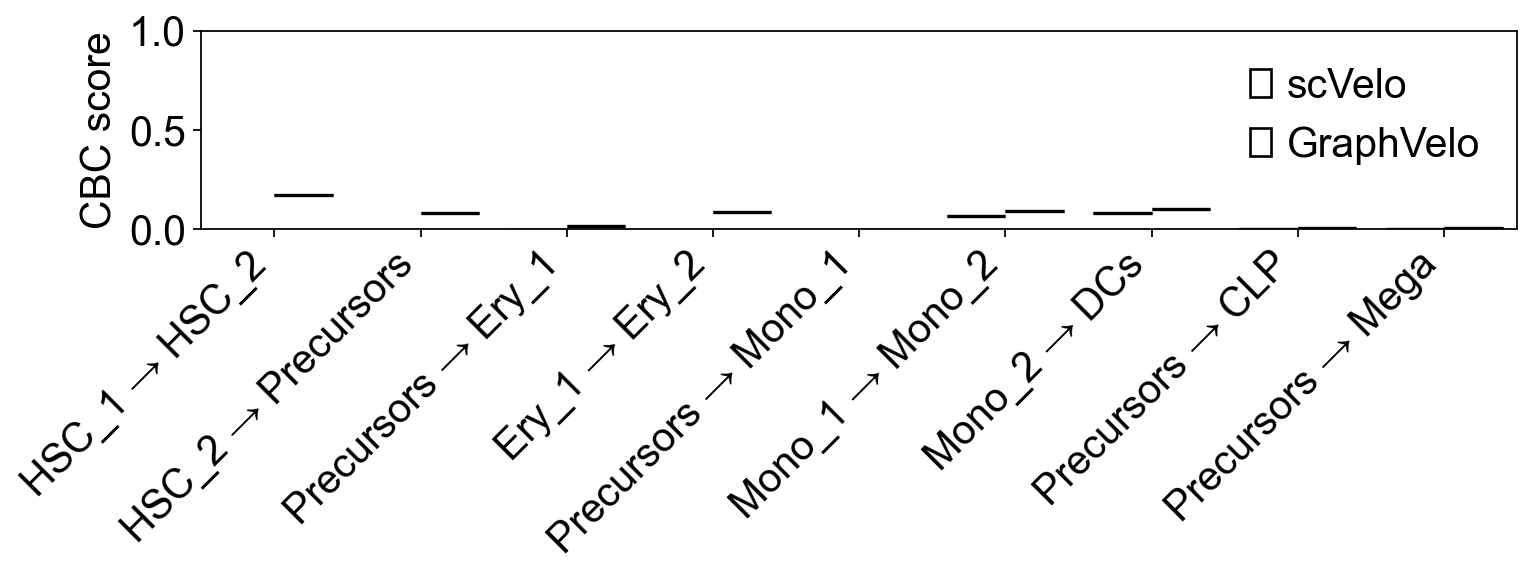

In [56]:
import pandas as pd

transitions_list = [f"{a} → {b}" for a, b in transitions]

df = pd.DataFrame({
    "Transition": transitions_list * 2,
    "CBC": cbc_sc_all + cbc_gv_all,
    "Method": ["scVelo"] * len(cbc_sc_all) + ["GraphVelo"] * len(cbc_gv_all)
})
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))

sns.boxplot(
    data=df,
    x="Transition",
    y="CBC",
    hue="Method",
    palette=["white", "white"],
    showcaps=True,
    boxprops=dict(edgecolor="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.5),
)

plt.ylim(0, 1)   # CBC is usually [0,1]
plt.xticks(rotation=45, ha="right")
plt.ylabel("CBC score")
plt.xlabel("")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


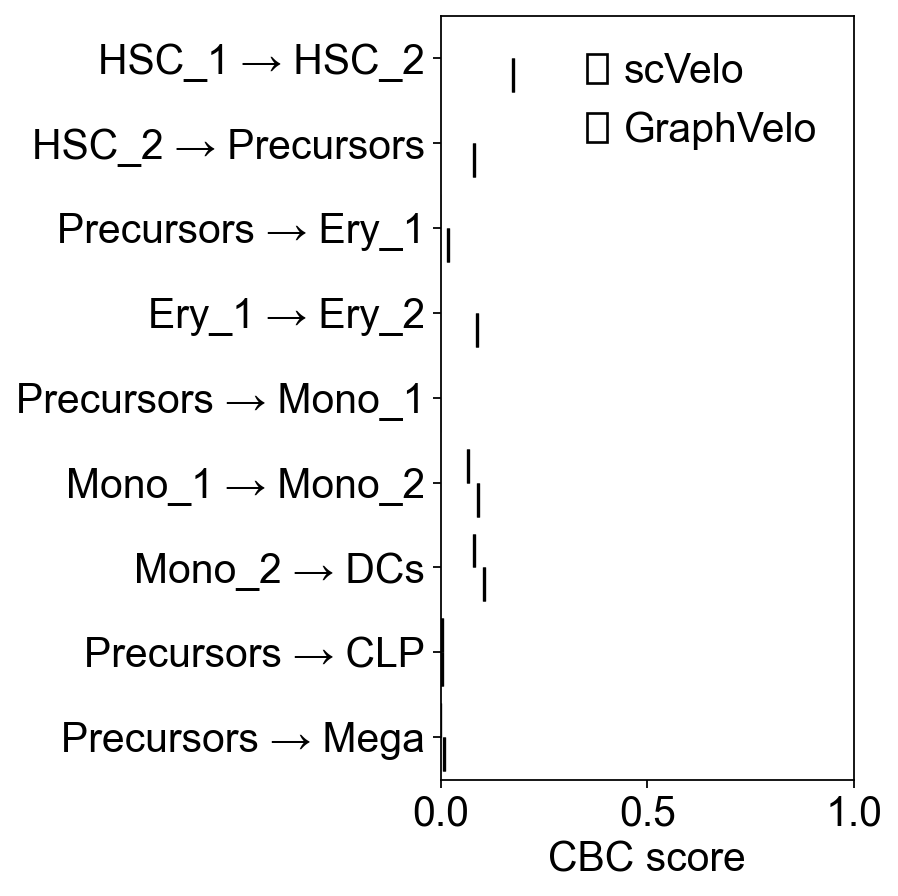

In [58]:
plt.figure(figsize=(6, 6))

sns.boxplot(
    data=df,
    y="Transition",
    x="CBC",
    hue="Method",
    palette=["white", "white"],
    showcaps=True,
    boxprops=dict(edgecolor="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.5),
)

plt.xlim(0, 1)
plt.xlabel("CBC score")
plt.ylabel("")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


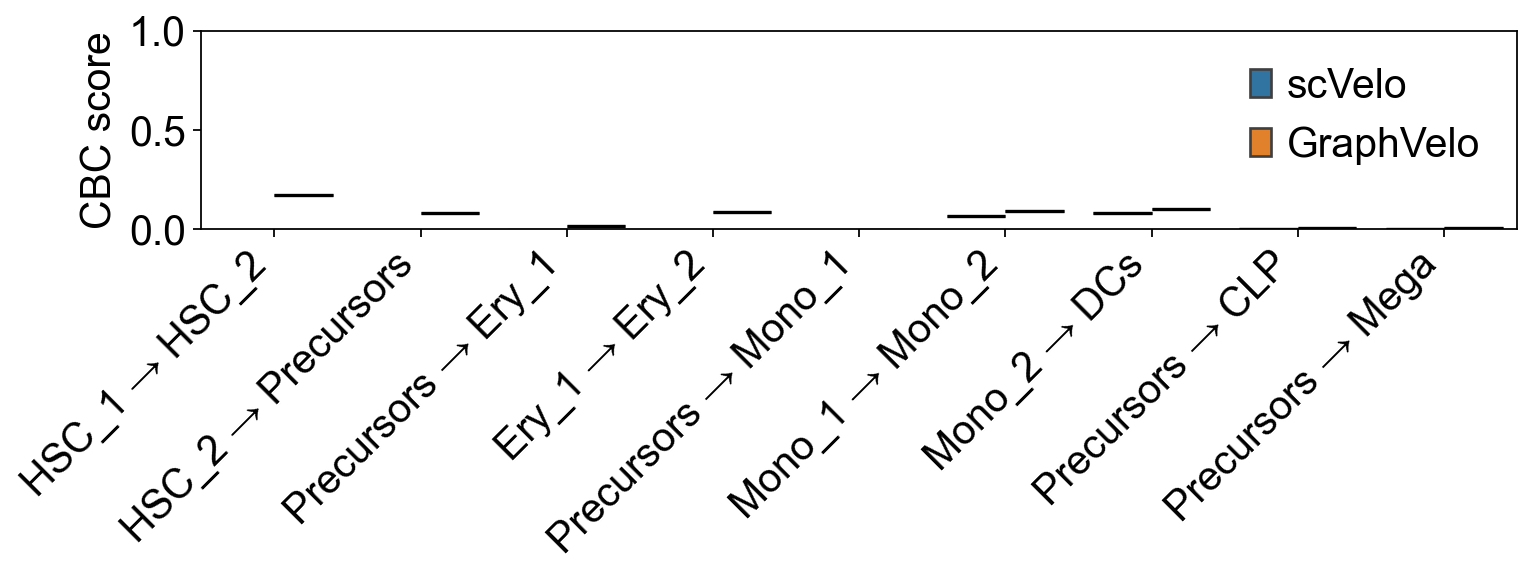

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# nice colour pair (blue vs orange)
palette = {
    "scVelo": "#1f77b4",
    "GraphVelo": "#ff7f0e"
}

plt.figure(figsize=(10,4))

sns.boxplot(
    data=df,
    x="Transition",
    y="CBC",
    hue="Method",
    palette=palette,
    showcaps=True,
    boxprops=dict(linewidth=1.2),
    whiskerprops=dict(linewidth=1.2),
    capprops=dict(linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.5)
)

plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("CBC score")
plt.xlabel("")
plt.legend(title="", frameon=False)
plt.tight_layout()
plt.show()


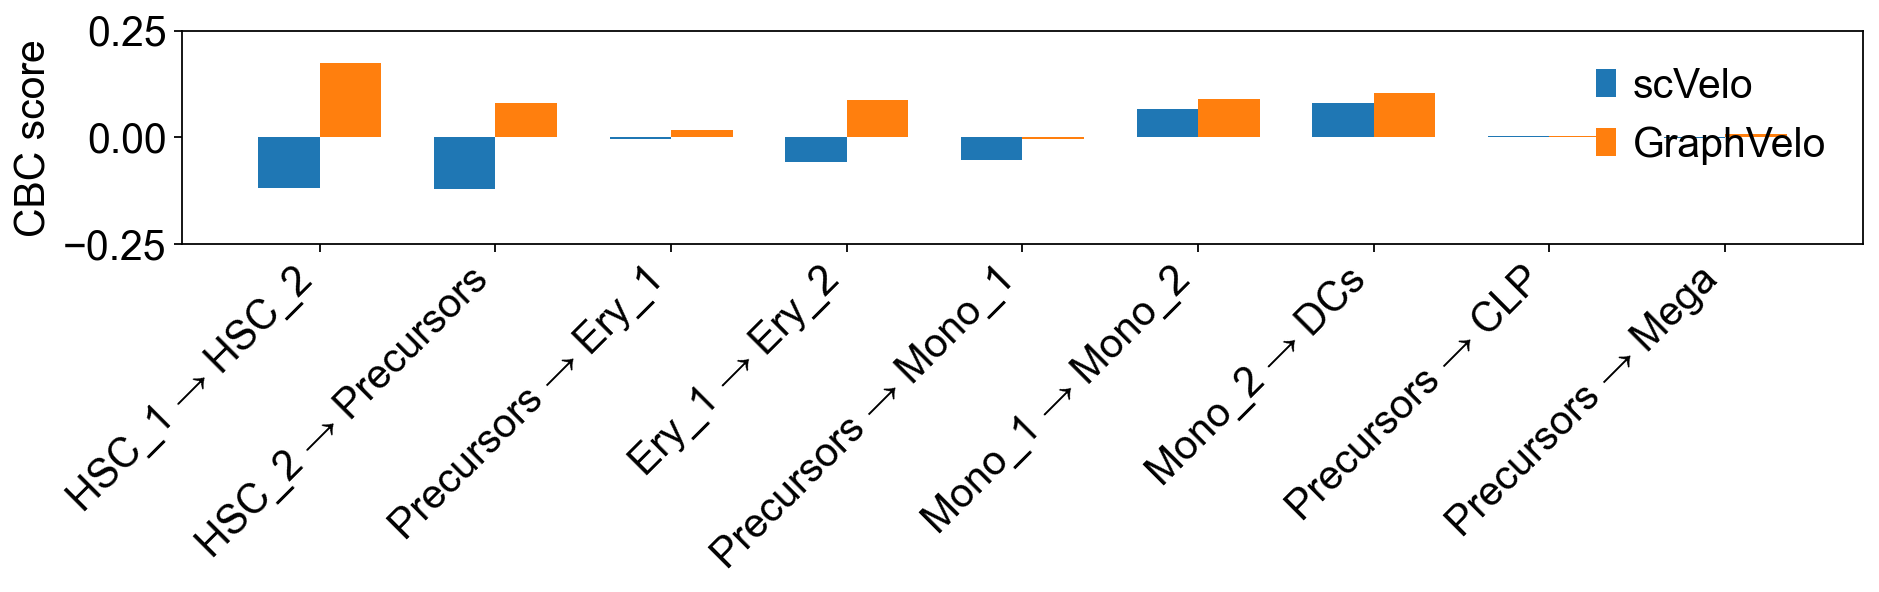

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Convert transitions to nice labels
transitions_list = [f"{a} → {b}" for a, b in transitions]

# data
sc = np.array(cbc_sc_all)
gv = np.array(cbc_gv_all)

x = np.arange(len(transitions_list))
width = 0.35

plt.figure(figsize=(12,4))

plt.bar(x - width/2, sc, width, label="scVelo", color="#1f77b4")
plt.bar(x + width/2, gv, width, label="GraphVelo", color="#ff7f0e")

plt.xticks(x, transitions_list, rotation=45, ha="right")
plt.ylabel("CBC score")
plt.ylim(-0.25, 0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


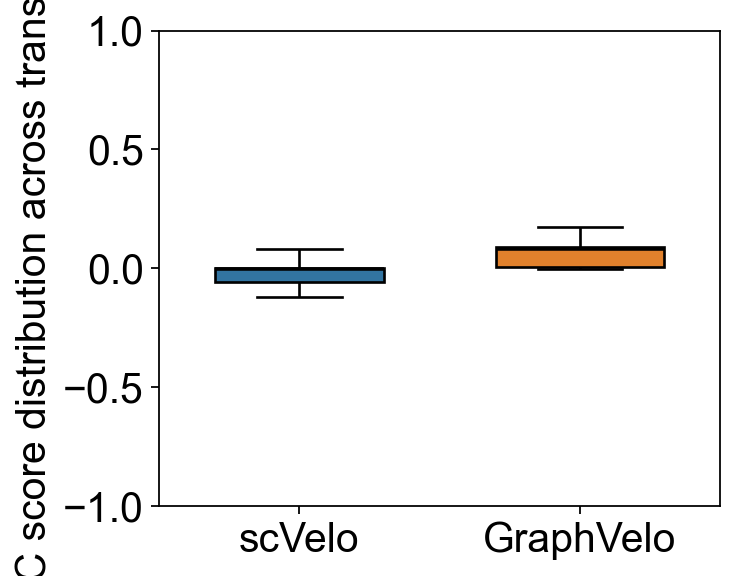

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "CBC": np.concatenate([sc, gv]),
    "Method": ["scVelo"] * len(sc) + ["GraphVelo"] * len(gv)
})

plt.figure(figsize=(5,4))

sns.boxplot(
    data=df,
    x="Method",
    y="CBC",
    palette={"scVelo": "#1f77b4", "GraphVelo": "#ff7f0e"},
    width=0.6,
    showcaps=True,
    boxprops=dict(edgecolor="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    medianprops=dict(color="black", linewidth=1.6)
)

plt.ylim(-1, 1)
plt.ylabel("CBC score distribution across transitions")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [59]:
# Calculate degradation rates 
from project.graphvelo.metric import calculate_degradation_graphvelo
calculate_degradation_graphvelo(
    adata,
    splice_key="Ms",          # spliced counts
    unsplice_key="Mu",        # unspliced counts
    velocity_key="velocity_gvs",  # GraphVelo spliced velocity
    degradation_key="graphvelo_degradation"
)

scvelo_gamma = adata.var['fit_gamma']  # shape: (n_genes,)
print(scvelo_gamma.head())


index
CCNL2          NaN
CDK11A         NaN
NADK      0.213168
CEP104         NaN
RERE           NaN
Name: fit_gamma, dtype: float64


In [49]:
adata.layers["graphvelo_degradation"]

array([[ 5.79310630e-01,  1.80778715e+00,  3.57221424e-02, ...,
         1.08719503e+01,  7.42734980e+00, -3.03334986e-01],
       [ 7.10086971e-01,  3.43369504e+00,            -inf, ...,
         8.50340760e+00,  6.23049068e-01,  1.25665439e-01],
       [-4.18436475e-02,  1.05043277e+00,  1.56532220e+00, ...,
         3.91394146e+01,             inf,  2.10838500e-01],
       ...,
       [-2.57337285e-02,  8.86722886e-01,  1.76925774e+00, ...,
         1.87454489e+01,  7.84504259e+00,  7.55464285e-01],
       [-7.88065544e-01,  2.89118123e+00,  2.16988795e-01, ...,
         3.62559227e+01,  6.84530664e-01,  1.47601156e+00],
       [ 3.40662174e-01,  3.69409406e+00,  7.48135678e-01, ...,
         6.83813835e+01,  5.10152104e-01,  5.12214584e-01]])

In [ ]:
# jaccbian

In [1]:
import dynamo as dyn

C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\anndata\__init__.py:70: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\anndata\__init__.py:70: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\anndata\__init__.py:70: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\annda

In [3]:
print(dyn.__version__)

1.4.3


In [ ]:
import dynamo as dyn

# For scVelo velocities
dyn.tl.vector_field(adata_scvelo, basis='pca')

# For GraphVelo velocities
dyn.tl.vector_field(adata_graphvelo, basis='pca')

# Compute Jacobians
dyn.tl.jacobian(adata_scvelo, regulators=['Gata1', 'Gata2'], effectors=['Klf1'])
dyn.tl.jacobian(adata_graphvelo, regulators=['Gata1', 'Gata2'], effectors=['Klf1'])


In [31]:
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'palantir', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'gv_params'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'X_pca', 'velocity_tsne', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspli

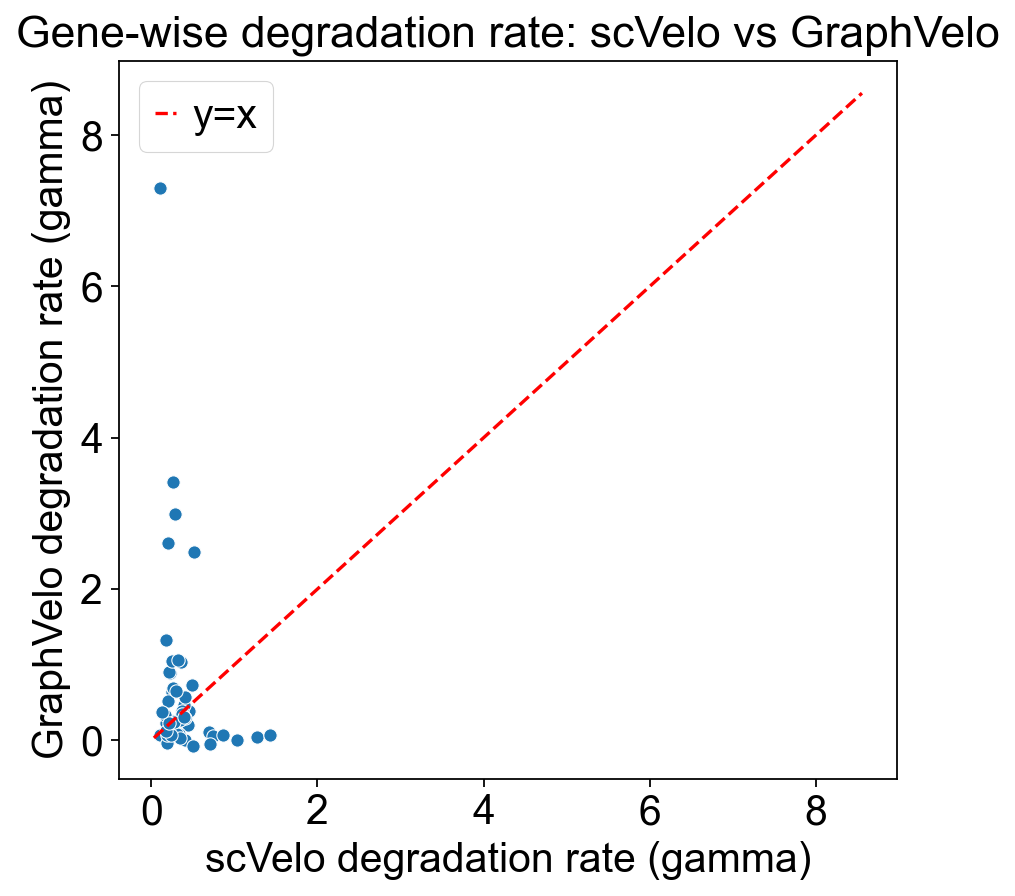

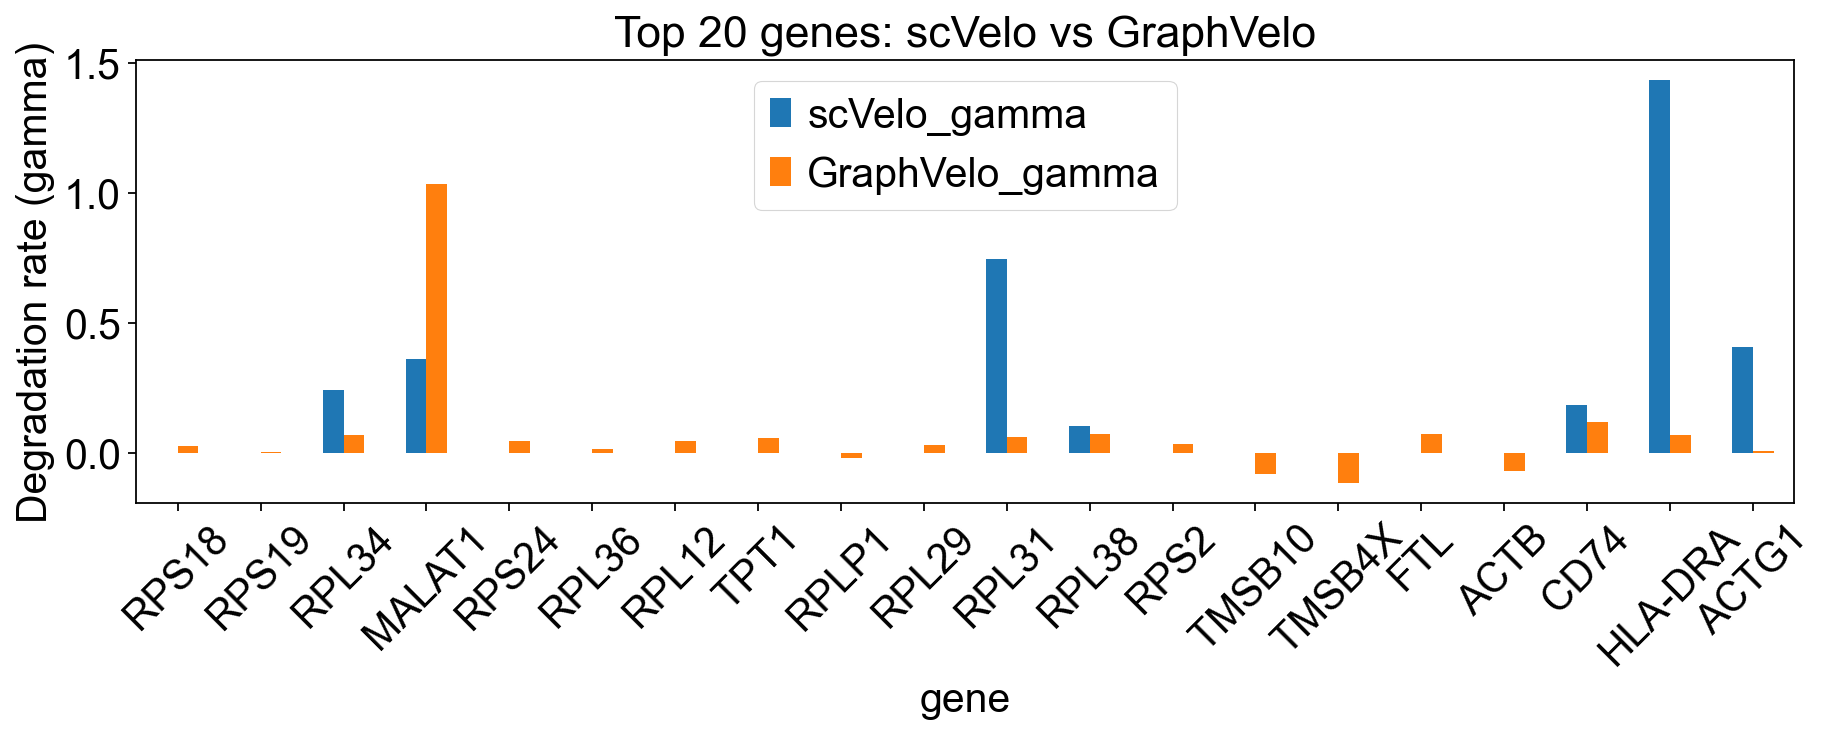

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- 1. Average GraphVelo degradation per gene ----------------
gamma_gv = np.mean(adata.layers['graphvelo_degradation'], axis=0)
gamma_gv = pd.Series(gamma_gv, index=adata.var_names)

# ---------------- 2. scVelo degradation per gene ----------------
gamma_scv = adata.var['fit_gamma']

# Ensure common genes
common_genes = gamma_scv.index.intersection(gamma_gv.index)
gamma_scv = gamma_scv.loc[common_genes]
gamma_gv = gamma_gv.loc[common_genes]

# ---------------- 3. Scatter plot ----------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=gamma_scv, y=gamma_gv)
plt.plot([gamma_scv.min(), gamma_scv.max()],
         [gamma_scv.min(), gamma_scv.max()],
         color='red', linestyle='--', label='y=x')
plt.xlabel('scVelo degradation rate (gamma)')
plt.ylabel('GraphVelo degradation rate (gamma)')
plt.title('Gene-wise degradation rate: scVelo vs GraphVelo')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- 4. Bar plot of top 20 expressed genes ----------------
top_genes = adata.var['means'].sort_values(ascending=False).head(20).index
df_plot = pd.DataFrame({
    'gene': top_genes,
    'scVelo_gamma': gamma_scv.loc[top_genes],
    'GraphVelo_gamma': gamma_gv.loc[top_genes]
}).set_index('gene')

df_plot.plot(kind='bar', figsize=(12,5))
plt.ylabel('Degradation rate (gamma)')
plt.title('Top 20 genes: scVelo vs GraphVelo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


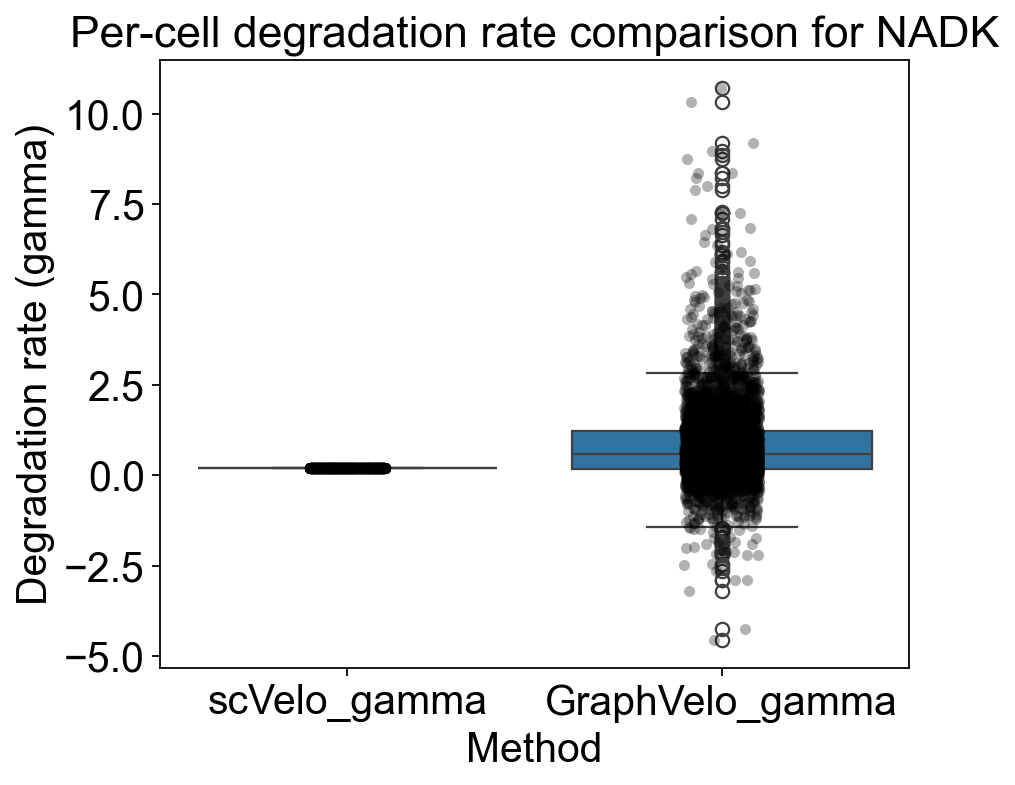

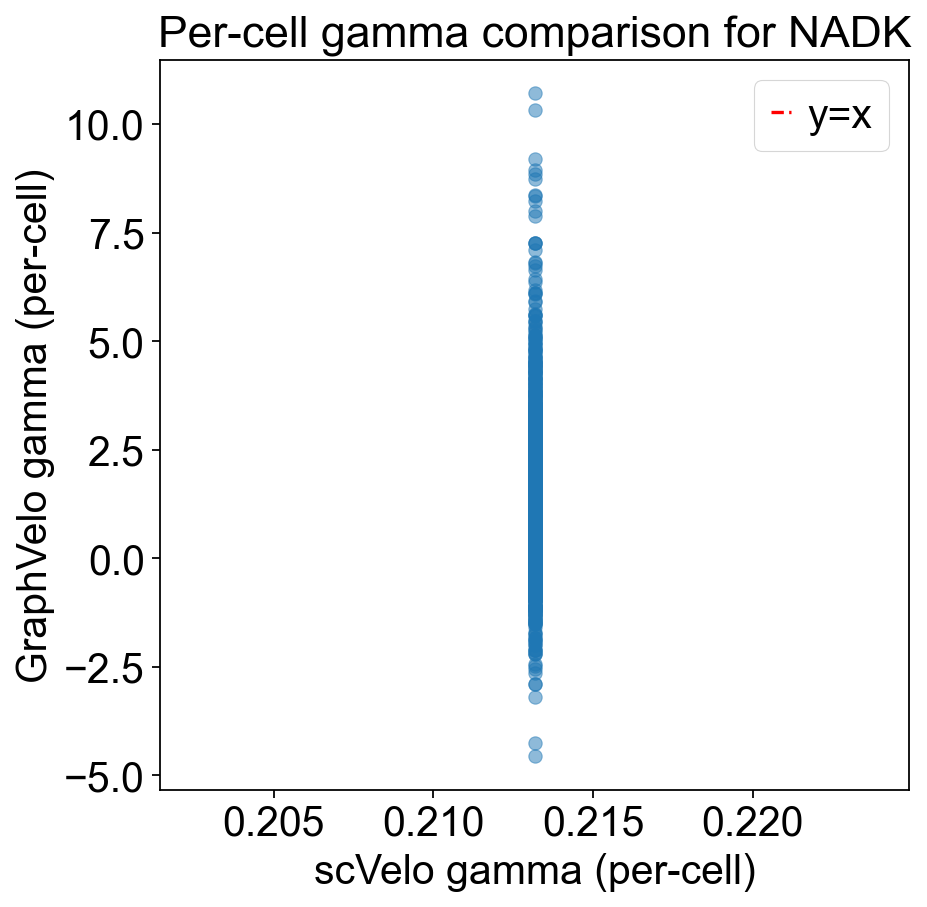

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gene = "NADK"

# Check that gene exists
if gene not in adata.var_names:
    raise ValueError(f"{gene} not in adata.var_names")

# ---------------- 1. Get GraphVelo degradation (cell-wise) ----------------
gv_gamma_cells = adata.layers['graphvelo_degradation'][:, adata.var_names.get_loc(gene)]

# ---------------- 2. Get scVelo degradation (broadcast across cells) ----------------
scv_gamma_cells = np.full(adata.n_obs, adata.var.loc[gene, 'fit_gamma'])

# ---------------- 3. Make DataFrame for plotting ----------------
df_plot = pd.DataFrame({
    'cell': adata.obs_names,
    'scVelo_gamma': scv_gamma_cells,
    'GraphVelo_gamma': gv_gamma_cells
})

# Melt for seaborn
df_melt = df_plot.melt(id_vars='cell', value_vars=['scVelo_gamma', 'GraphVelo_gamma'],
                       var_name='Method', value_name='Degradation')

# ---------------- 4. Boxplot ----------------
plt.figure(figsize=(6,5))
sns.boxplot(x='Method', y='Degradation', data=df_melt)
sns.stripplot(x='Method', y='Degradation', data=df_melt, color='black', alpha=0.3, jitter=True)
plt.title(f'Per-cell degradation rate comparison for {gene}')
plt.ylabel('Degradation rate (gamma)')
plt.show()

# ---------------- 5. Scatter plot: cell-wise comparison ----------------
plt.figure(figsize=(6,6))
plt.scatter(scv_gamma_cells, gv_gamma_cells, alpha=0.5)
plt.plot([scv_gamma_cells.min(), scv_gamma_cells.max()],
         [scv_gamma_cells.min(), scv_gamma_cells.max()],
         color='red', linestyle='--', label='y=x')
plt.xlabel('scVelo gamma (per-cell)')
plt.ylabel('GraphVelo gamma (per-cell)')
plt.title(f'Per-cell gamma comparison for {gene}')
plt.legend()
plt.show()


In [55]:
import numpy as np
# Function for mack gene calculation
def calculate_mack_score_numba(x, v, nbrs_idx, t, eps=1e-5):
    score = np.zeros(x.shape[0])
    # for each cell
    for i in range(x.shape[0]):
        nbrs = nbrs_idx[i]
        # for each neighbor
        for j in range(len(nbrs)):
            # expression change
            d_x = x[i] - x[nbrs[j]]
            # Pseudotime change
            d_t = t[i] - t[nbrs[j]] + eps # avoid division by zero
            
            # calculate teh sign (should be 1, -1, or 0, I think d_x do not ahve nan)
            sign = d_x / d_t
            if sign > 0:
                sign = 1
            elif sign < 0:
                sign = -1
            elif sign == 0:
                sign = 0
            
            s_v = v[i]
            if s_v > 0:
                s_v = 1
            elif s_v < 0:
                s_v = -1
            elif s_v == 0:
                s_v = 0

            if sign == s_v:
                score[i] += 1
            else:
                score[i] += 0

        score[i] /= len(nbrs)
    return score


from pynndescent import NNDescent # for "pynn", "umap"
from sklearn.neighbors import NearestNeighbors # for "ball_tree", "kd_tree"
def knn(
    X: np.ndarray,
    k: int,
#    query_X: Optional[np.ndarray] = None,
    method: str = "kd-tree", # options: "kd-tree", "PyNNDescent" and "Ball tree"
#    exclude_self: bool = True,
#    knn_dim: int = 10,
#    pynn_num: int = 5000,
#    pynn_dim: int = 2,
    pynn_rand_state: int = 0,
#    n_jobs: int = -1,
#    return_nbrs: bool = False,
#    **kwargs,
):
    
    if method.lower() in ["pynn", "umap"]:
        nbrs = NNDescent(X, n_neighbors= k + 1, random_state= pynn_rand_state)
        nbrs_idx, distances = nbrs.query(X, k=k+1)
    elif method.lower() in ["ball_tree", "kd_tree"]:
        nbrs = NearestNeighbors(n_neighbors= k+1, algorithm= method.lower()).fit(X)
        nbrs_idx, distances = nbrs.kneighbors(X, n_neighbors=k + 1, return_distance=True)
    else:
        print("Using default method kd-tree for knn")
        nbrs = NearestNeighbors(n_neighbors= k+1, algorithm= "kd-tree").fit(X)
        nbrs_idx, distances = nbrs.kneighbors(X, n_neighbors=k + 1, return_distance=True)

    # remove self-neighbour
    nbrs_idx = nbrs_idx[:, 1:]
    distances = distances[:, 1:]

    return nbrs_idx, distances, nbrs, method



from numba import njit, prange
import numpy as np

@njit(parallel=True)
def compute_all_mack_scores(X_data, V_data, nbrs_idx, t, eps=1e-5):
    n_cells, n_genes = X_data.shape
    out = np.zeros(n_genes)

    for gene_i in prange(n_genes):     # <--- parallel across genes!
        x = X_data[:, gene_i]
        v = V_data[:, gene_i]
        n = x.shape[0]
        score = 0.0

        for i in range(n):
            nbrs = nbrs_idx[i]
            ln = len(nbrs)
            c = 0
            for j in range(ln):
                d_x = x[i] - x[nbrs[j]]
                d_t = t[i] - t[nbrs[j]] + eps

                # sign(d_x / d_t)
                r = d_x / d_t
                if r > 0:
                    sign = 1
                elif r < 0:
                    sign = -1
                else:
                    sign = 0

                s_v = v[i]
                if s_v > 0:
                    s_v = 1
                elif s_v < 0:
                    s_v = -1
                else:
                    s_v = 0

                if sign == s_v:
                    c += 1

            score += c / ln

        out[gene_i] = score / n  # mean of all cells for this gene

    return out


def gv_mack_score(
    adata,
    n_neighbors=None,
    basis=None,
    tkey=None,
    genes=None,
    ekey="M_s",
    vkey="velocity_S",
    X_data=None,
    V_data=None,
    n_jobs=-1,
    add_prefix=None,
    return_score=False,
):
    
         # Determine the number of jobs to use.
    if (n_jobs is None or not isinstance(n_jobs, int) or n_jobs < 0 or
            n_jobs > os.cpu_count()):
        n_jobs = os.cpu_count()

    # Restrict genes if provided.
    if genes is not None:
        genes = adata.var_names.intersection(genes).to_list()
        if len(genes) == 0:
            raise ValueError("No genes from your genes list appear in your adata object.")
    else:
        tmp_V = adata.layers[vkey].A if sp.issparse(adata.layers[vkey]) else adata.layers[vkey]
        genes = adata[:, ~np.isnan(tmp_V.sum(0))].var_names

    # Get X_data and V_data if not provided.
    if X_data is None or V_data is None:
        X_data = adata[:, genes].layers[ekey]
        V_data = adata[:, genes].layers[vkey]
    else:
        if V_data.shape[1] != X_data.shape[1] or len(genes) != X_data.shape[1]:
            raise ValueError(
                f"When providing X_data, a list of gene names that corresponds to the columns of X_data "
                f"must be provided")
    
    # Get kNN indices.
    if n_neighbors is None:
        nbrs_idx = adata.uns['neighbors']['indices']
    else:
        basis_for_knn = 'X_' + basis
        if basis_for_knn in adata.obsm.keys():
#            logging.info(f"Compute knn in {basis.upper()} basis...")
            nbrs_idx, _, _, _ = knn(adata.obsm[basis_for_knn], n_neighbors)
        else:
#            logging.info(f"Compute knn in original basis...")
            X_for_knn = adata.X.A if sp.issparse(adata.X) else adata.X
            nbrs_idx, _, _, _ = knn(X_for_knn, n_neighbors)


    # Get pseudotime
    t_annot = adata.obs[tkey]

    if hasattr(t_annot, "to_numpy"):
        t_data = t_annot.to_numpy()
    else:
        t_data = np.array(t_annot)

    t = t_data.flatten()

    scores = compute_all_mack_scores(X_data, V_data, nbrs_idx, t)

    rows = []
    for gene_i, gene in enumerate(genes):
       rows.append((gene, scores[gene_i]))



    mack_score_results = pd.DataFrame(rows, columns=["gene_name", "mack_score"])


    mack_score_results = mack_score_results.reset_index().set_index("gene_name")
    mack_score_results = mack_score_results.astype({"mack_score": "float64"})

    velo_conf_key = "mack_score"
    adata.var[velo_conf_key] = np.nan
    adata.var.loc[genes, velo_conf_key] = mack_score_results.loc[genes, "mack_score"]   

        


In [31]:
from typing import Optional, List, Dict, Tuple, Union

In [73]:
gv_mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

In [39]:
import os

In [43]:
import scipy.sparse as sp

In [51]:
from tqdm import tqdm 

In [61]:
import pandas as pd

In [65]:
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'palantir', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types', 'log1p', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'X_pca', 'velocity_tsne', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspliced', 'Ms', '

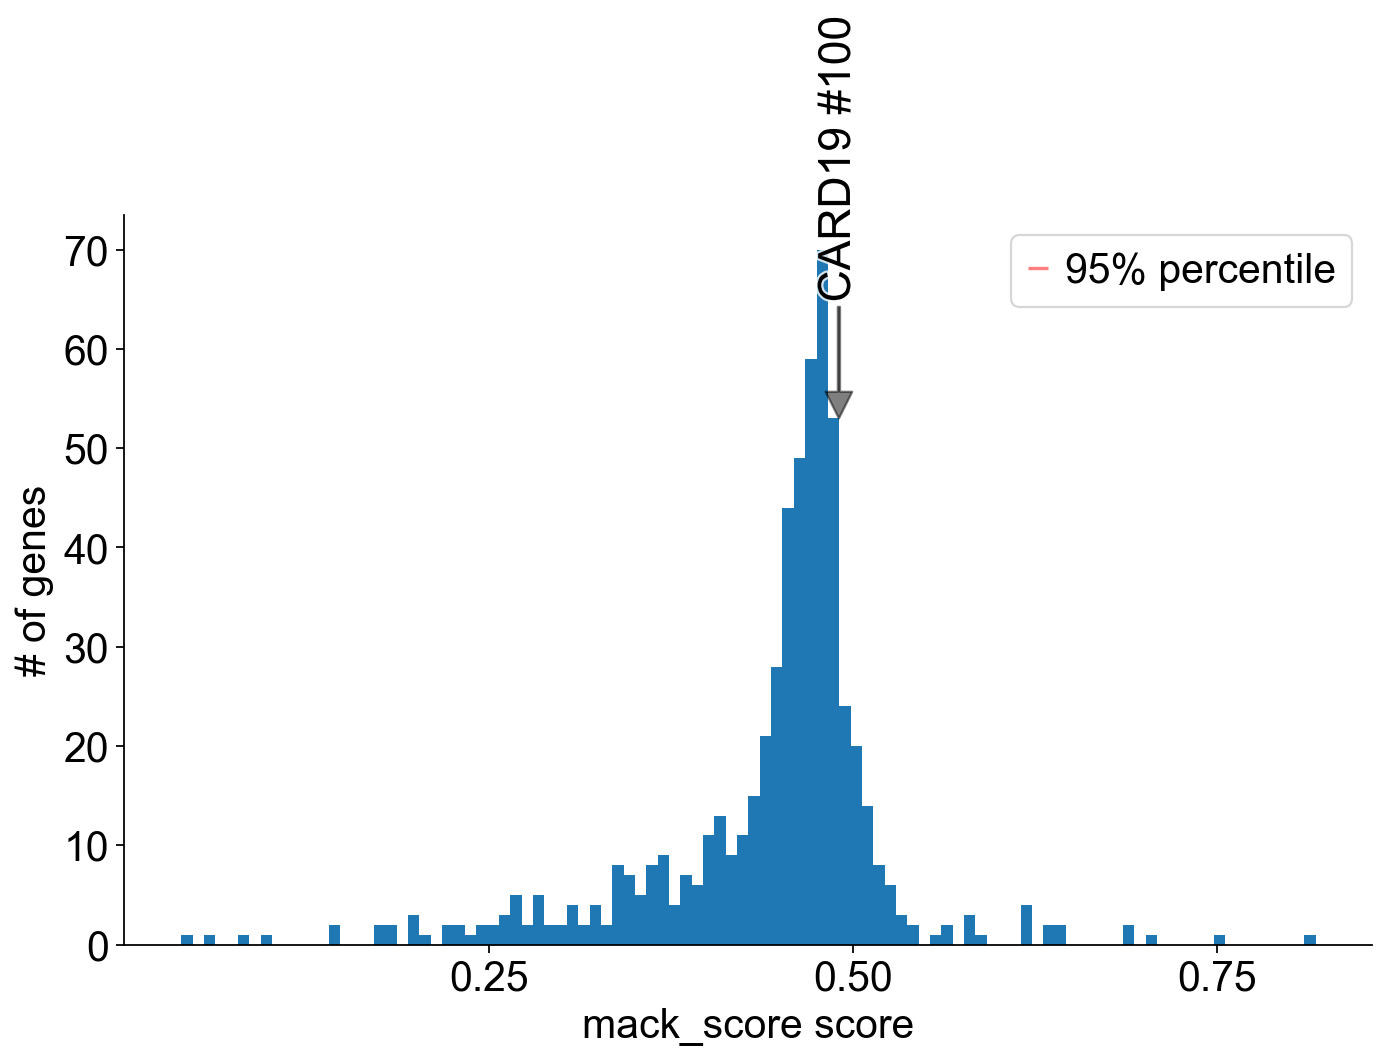

In [67]:
nbrs_idx = adata.uns['neighbors']['indices']
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

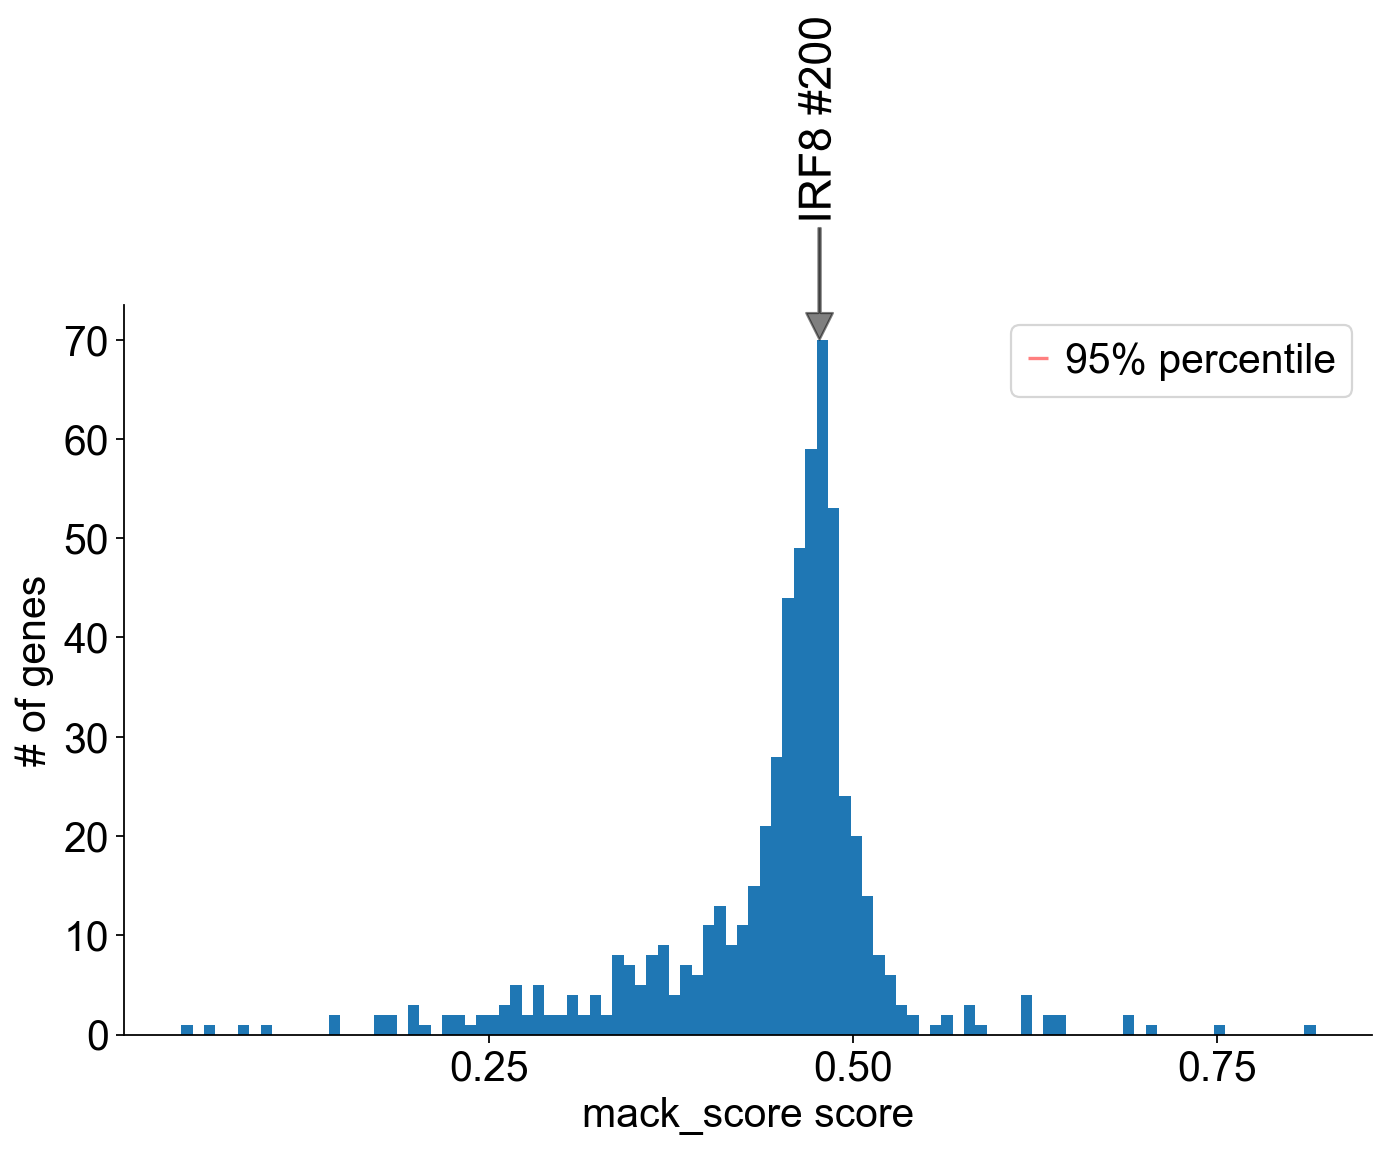

In [69]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|█████████████████████████████████| 5780/5780 [00:51<00:00, 111.56it/s]
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


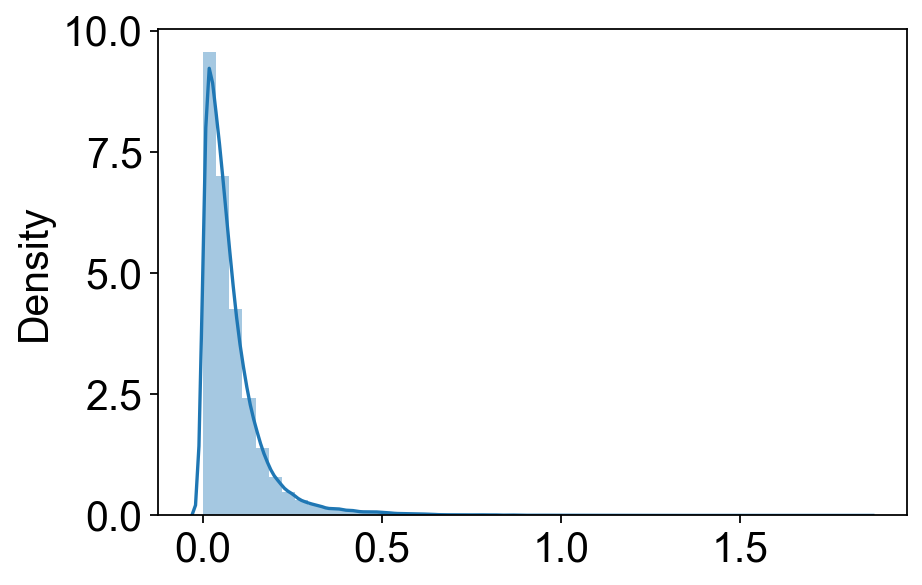

In [71]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()